#### Initial imports

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

#### Set processing parameters

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
USE_PARALLEL = False
use_downscaled = False
use_minscaled = True

### Prep lists of input files

In [3]:
from glob import glob
import re
import pandas as pd
from random import sample, seed

In [4]:
encoder_list = ['resnet34']
avail_suffix = ['rgb', 'tpi', 'shade', 'ndvi', 'dsm']

In [5]:
# set working directory
#os.chdir('/project/cper_neon_aop/cper_pdog_uas')

# set directories for training data and labels
if use_downscaled:
    DATA_FOLDER = './cnn_train_images_downscaled/{}_{}.tif'
    LABEL_FOLDER = './cnn_train_labels_downscaled/{}_labels.tif'
elif use_minscaled:
    DATA_FOLDER = './cnn_train_images_minscaled/{}_{}.tif'
    LABEL_FOLDER = './cnn_train_labels_minscaled/{}_labels.tif'
else:
    DATA_FOLDER = './cnn_train_images/{}_{}.tif'
    LABEL_FOLDER = './cnn_train_labels/{}_labels.tif'

In [6]:
# read in csvs with training information
df_tiles = pd.read_csv('train_tiles/train_bboxes_all_assigned.csv')
df_polys = pd.read_csv('train_polys/train_polys_all.csv')

In [7]:
# get all ids to be used
label_files = glob(LABEL_FOLDER.replace('{}', '*'))
all_ids = [re.sub('_labels.tif', '', os.path.basename(f)) for f in label_files]
all_tiles = list(set(['_'.join(y.split('_')[2:]) for y in all_ids]))

In [8]:
# separate training and test data and get paths to files
all_files = glob(DATA_FOLDER.replace('{}', '*'))
all_train_tiles = [x for x in df_tiles.apply(lambda x: '_'.join([x.Pasture, x.Tile]) if x.Train == 1 else '', axis=1) if x != '' and x in all_tiles]
test_tiles = list(set(all_tiles) - set(all_train_tiles))

all_train_ids = [x for x in all_ids if '_'.join(x.split('_')[-3:]) in all_train_tiles]
test_ids = list(set(all_ids) - set(all_train_ids))

seed(321)
valid_ids = sample(all_train_ids, int(np.ceil(len(all_train_ids)*0.3)))
train_ids = list(set(all_train_ids) - set(valid_ids))

train_files = [f for f in all_files if '_'.join(os.path.basename(f).split('_')[:-1]) in train_ids]
valid_files = [f for f in all_files if '_'.join(os.path.basename(f).split('_')[:-1]) in valid_ids]
test_files = [f for f in all_files if '_'.join(os.path.basename(f).split('_')[:-1]) in test_ids]

In [9]:
tile_ids = df_tiles[(df_tiles['trainer'] != 'Nick') &
                    (df_tiles['Digitize'] == 1)].apply(lambda x: '_'.join([x.Pasture, x.Tile]), axis=1)
#all_tiles#
[x for x in all_tiles if x not in tile_ids.to_list()]

[]

In [10]:
[x for x in tile_ids.to_list() if x not in all_tiles]

[]

### Dataloader
Writing helper class for data extraction, tranformation and preprocessing

In [11]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from skimage import io
from skimage.transform import resize

In [12]:
class Dataset(BaseDataset):
    """Read images, apply augmentation and preprocessing transformations.
    
    Args:
        ids (list): list of unique ids for all images
        images_path (str): path to data images
        masks_path (str): path to label masks
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    
    CLASSES = ['other', 'burrow']
    
    def __init__(
            self, 
            ids,
            suffix_list,
            images_path,
            masks_path, 
            classes=None, 
            newsize=None,
            augmentation=None, 
            preprocessing=None,
            suffix_dict = {
        'rgb': {'channels': 3,
                'dtype': 'uint8'},
        'tpi': {'channels': 1,
                'dtype': 'float32'},
        'dsm': {'channels': 1,
                'dtype': 'float32'},
        'shade': {'channels': 1,
                  'dtype': 'float32'},
        'ndvi': {'channels': 1,
                  'dtype': 'float32'}
    }
    ):
        # get IDs as attribute
        self.ids = ids
        
        # get suffix info
        self.suffix_dict = suffix_dict
        
        # get list of suffixes as attribute
        self.suffix_list = suffix_list
        
        # List of files
        self.images_fps = []
        self.masks_fps = [masks_path.format(id) for id in ids]
        for id in ids:
            self.images_fps.append({s: images_path.format(id, s) for s in suffix_list})
            
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.newsize=newsize
    
    def __getitem__(self, i):
        
        # read data
        image_list = []
        self.image_dict = {}
        for s in self.suffix_list:
            image_s = np.asarray(io.imread(self.images_fps[i][s]), dtype=self.suffix_dict[s]['dtype'])
            if len(image_s.shape) == 2:
                image_s = np.expand_dims(image_s, axis=-1)
            image_s[np.isnan(image_s)] = 0
            if s == 'ndvi':
                image_s[image_s < 0] = 0
            if self.preprocessing:
                image_s = normalize_fn(image_s, s, image_stats)
            if self.newsize is not None and self.newsize != image_s.shape[0]:
                image_s = resize(image_s, (self.newsize, self.newsize), anti_aliasing=True, order=1)
            image_list.append(image_s)
            self.image_dict[s] = image_s
        if len(image_list) == 1:
            image = image_list[0]
        else:
            image = np.concatenate(image_list, axis=-1)
        mask = np.asarray(io.imread(self.masks_fps[i]), dtype='float32')
        if self.newsize is not None and self.newsize != mask.shape[0]:
            mask = resize(mask, (self.newsize, self.newsize), anti_aliasing=True, order=1)
            mask = mask >= 0.5
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1)#.astype('float32')
        #print('fetched: ', self.ids[i])
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # convert final image arrays to tensors
        image = torch.from_numpy(image.transpose(2, 0, 1).astype('float32'))
        mask = torch.from_numpy(mask.transpose(2, 0, 1).astype('float32'))
        return image, mask
        
    def __len__(self):
        return len(self.ids)




### Augmentations

In [13]:
import albumentations as albu
import random

In [14]:
def get_training_augmentation():
    train_transform = [
        
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),
        #albu.RandomCrop(height=win_size, width=win_size, always_apply=True),

        #albu.GaussNoise(p=0.2, var_limit=1.0),
        #albu.Perspective(p=0.5),

        #albu.OneOf(
        #    [
        #        #albu.CLAHE(p=1), # required int8 images
        #        albu.RandomBrightnessContrast(p=1),
        #        #albu.RandomGamma(p=1),
        #        #albu.HueSaturationValue(p=1),
        #    ],
        #    p=0.9,
        #),

        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=(3, 7), p=1),
                albu.MotionBlur(blur_limit=(3, 7), p=1),
            ],
            p=0.25,
        ),
    ]
    return albu.Compose(train_transform)

### Create preprocessing function from training data stats

In [15]:
import torch
import numpy as np

In [16]:
CLASSES = ['burrow']

In [17]:
image_stats = {
    'rgb': {'min': 0.0,
            'max': 255.0},
    'ndvi': {'min': 0.0,
             'max': 1.0}
}

In [18]:
for suffix_list in [['tpi'], ['shade']]:
    train_dataset = Dataset(
        train_ids,
        suffix_list,
        DATA_FOLDER,
        LABEL_FOLDER,
        classes=CLASSES)
    #train_dataset[0][0].cpu().numpy().shape
    min_list = []
    max_list = []
    for i in range(len(train_dataset)):
        min_list.append(np.min(train_dataset[i][0].cpu().numpy()))
        max_list.append(np.max(train_dataset[i][0].cpu().numpy()))
    image_stats[suffix_list[0]] = {
        'min': np.min(min_list),
        'max': np.max(max_list)
    }

In [19]:
df_image_stats = pd.DataFrame(image_stats).reset_index().rename(
    columns={'index': 'stat'})
if use_downscaled:
    df_image_stats.to_csv('./_utils/image_stats_downscaled.csv', index=False)
elif use_minscaled:
    df_image_stats.to_csv('./_utils/image_stats_minscaled.csv', index=False)
#else:
#    df_image_stats.to_csv('./_utils/image_stats.csv', index=False)

In [20]:
# create function to normalize all data in range 0-1
def normalize_fn(image, image_suffix, stats_dict):
    if image_suffix in stats_dict.keys():
        min_tmp = stats_dict[image_suffix]['min']
        max_tmp = stats_dict[image_suffix]['max']
    else:
        # normalize to individual image if min/max stats not specified in dictionary
        min_tmp = np.min(image)
        max_tmp = np.max(image)
    return (image - min_tmp) / (max_tmp - min_tmp)
    
        

In [21]:
suffix_list = ['rgb']
train_dataset = Dataset(
        train_ids,
        suffix_list,
        DATA_FOLDER,
        LABEL_FOLDER,
        newsize=32 * 4,
        #augmentation=get_training_augmentation(),
        preprocessing=True,
        classes=CLASSES)
min_list_tmp = []
#for i in range(len(train_dataset)):
#    min_list_tmp.append(np.min(train_dataset[i][0].cpu().numpy()))
#np.min(min_list_tmp)

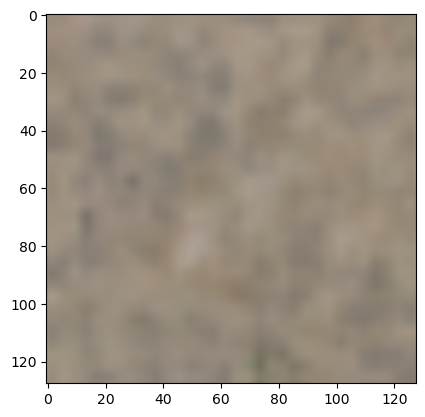

In [22]:
i = 2
try:
    plt.imshow(train_dataset[i][0].cpu().numpy().squeeze())
except TypeError:
    plt.imshow(train_dataset[i][0].cpu().numpy().transpose(1, 2, 0))

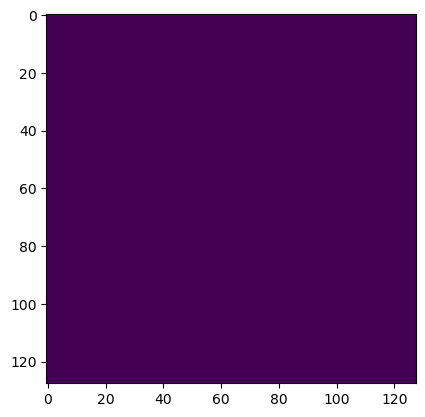

In [23]:
plt.imshow(train_dataset[i][1].cpu().numpy().squeeze())

### Create and train model

In [24]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils
import torch.nn as nn
import gc

In [25]:
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #'cuda'# 'cpu'# 

In [26]:
print(DEVICE)

cuda:0


In [27]:
import itertools
#list(itertools.combinations(avail_suffix, len(avail_suffix)))
suffix_combinations = list()
for n in range(1, len(avail_suffix) + 1):
    suffix_combinations += list(itertools.combinations(avail_suffix, n))

In [28]:
for mod in ['unetplus']:
    print('\n\n----------------------------------------------------------')
    print('----------------------------------------------------------')
    print('Now running model: ' + mod)
    print('----------------------------------------------------------')
    outDIR = './cnn_results_downscaled_' + mod + '/'
    if not os.path.exists(outDIR):
        os.mkdir(outDIR)
    for suffix_list in [['rgb', 'tpi', 'shade', 'ndvi'], ['rgb', 'tpi', 'shade', 'dsm'], ['rgb'], ['rgb', 'ndvi'], 
                        ['tpi'], ['rgb', 'tpi'], ['rgb', 'tpi', 'ndvi']]:
        print('----------------------------------------------------------')
        print(suffix_list)
        if use_downscaled:
            scale_list = [4, 2, 1]
        elif use_minscaled:
            scale_list = [1]
        else:
            scale_list = [6, 3, 2]
        for scale in scale_list:
            print('----------------------------------------------------------')
            newsize = 32 * scale
            print('Rescaled to: ' + str(newsize) + ' x ' + str(newsize) + ' pixels')
            if use_downscaled:
                scale_suffix = '_downscaled'
            elif use_minscaled:
                scale_suffix = '_minscaled'
            else:
                scale_suffix = '_scaled'
            if os.path.exists(outDIR + 'best_model_' + '_'.join(suffix_list) + scale_suffix + str(newsize) + '_validation.txt'):
                print('skipping - already trained.')
                continue
            else:
                train_dataset = Dataset(
                    train_ids,
                    suffix_list,
                    DATA_FOLDER,
                    LABEL_FOLDER,
                    newsize=newsize,
                    augmentation=get_training_augmentation(),
                    preprocessing=True,
                    classes=CLASSES)

                valid_dataset = Dataset(
                    valid_ids,
                    suffix_list,
                    DATA_FOLDER,
                    LABEL_FOLDER,
                    newsize=newsize,
                    #augmentation=get_validation_augmentation(),
                    preprocessing=True,
                    classes=CLASSES)


                train_loader = DataLoader(train_dataset, batch_size=6, shuffle=False,
                                          drop_last=True, num_workers=6, pin_memory=False)
                valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=6, pin_memory=False)

                # create segmentation model with pretrained encoder
                if mod == 'deeplabplus':
                    model = smp.DeepLabV3Plus(
                        encoder_name=ENCODER, 
                        encoder_weights=ENCODER_WEIGHTS, 
                        classes=len(CLASSES), 
                        activation=ACTIVATION,
                        in_channels=train_dataset[0][0].shape[0],
                    )
                elif mod == 'fpn':
                    model = smp.FPN(
                        encoder_name=ENCODER, 
                        encoder_weights=ENCODER_WEIGHTS, 
                        classes=len(CLASSES), 
                        activation=ACTIVATION,
                        in_channels=train_dataset[0][0].shape[0],
                    )
                elif mod == 'manet':
                    model = smp.MAnet(
                        encoder_name=ENCODER, 
                        encoder_weights=ENCODER_WEIGHTS, 
                        classes=len(CLASSES), 
                        activation=ACTIVATION,
                        in_channels=train_dataset[0][0].shape[0],
                    )
                elif mod == 'unetplus':
                    model = smp.UnetPlusPlus(
                        encoder_name=ENCODER, 
                        encoder_weights=ENCODER_WEIGHTS, 
                        classes=len(CLASSES), 
                        activation=ACTIVATION,
                        in_channels=train_dataset[0][0].shape[0],
                    )
                else:
                    print('ERROR: model "' + mod + '" not found!')
                    break

                if USE_PARALLEL:
                    model = nn.DataParallel(model)

                preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

                # Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
                # IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

                loss = smp.losses.MCCLoss()
                loss.__name__ = 'mccloss'
                metrics = [
                    utils.metrics.IoU(threshold=0.5),
                    utils.metrics.Accuracy(threshold=0.5),
                    utils.metrics.Precision(threshold=0.5),
                    utils.metrics.Recall(threshold=0.5),
                    utils.metrics.Fscore(threshold=0.5)
                ]

                optimizer = torch.optim.Adam([ 
                    dict(params=model.parameters(), lr=0.0001),
                ])

                # create epoch runners 
                # it is a simple loop of iterating over dataloader`s samples
                train_epoch = utils.train.TrainEpoch(
                    model, 
                    loss=loss, 
                    metrics=metrics, 
                    optimizer=optimizer,
                    device=DEVICE,
                    verbose=True,
                )

                valid_epoch = utils.train.ValidEpoch(
                    model, 
                    loss=loss, 
                    metrics=metrics, 
                    device=DEVICE,
                    verbose=True,
                )

                # train model for up to 60 epochs

                max_score = 0
                max_score_train = 0
                no_improve = 0

                for i in range(1, 61):

                    print('\nEpoch: {}'.format(i))
                    train_logs = train_epoch.run(train_loader)
                    valid_logs = valid_epoch.run(valid_loader)

                    # do something (save model, change lr, etc.)
                    if max_score < valid_logs['fscore']:
                        max_score = valid_logs['fscore']
                        max_score_train = train_logs['fscore']
                        torch.save(model, outDIR + 'best_model_' + '_'.join(suffix_list) + scale_suffix + str(newsize) + '.pth')
                        valid_logs['best_epoch'] = i
                        valid_logs['downscaled'] = use_downscaled
                        valid_logs['newsize'] = str(newsize) + 'x' + str(newsize) + 'px'
                        if use_downscaled:
                            valid_logs['origsize'] = '128x128px'
                            valid_logs['resolution'] = 15 * (128 / int(newsize))
                        elif use_minscaled:
                            valid_logs['origsize'] = '32x32px'
                            valid_logs['resolution'] = int((3000/32) * (32 / int(newsize)))
                        else:
                            valid_logs['origsize'] = '384x384px'
                            valid_logs['resolution'] = 1.5 * (384 / int(newsize))
                        best_valid_logs = valid_logs.copy()
                        print('Model saved!')
                        no_improve = 0
                    else:
                        no_improve += 1
                        print('No improvement in ' + str(no_improve) + ' epochs. Model not saved.')

                    if i > 15:
                        if no_improve >= 5:
                            if (train_logs['fscore'] - max_score_train) < 0.05:
                                print('More than 5 epochs without validation improvement while learning rate <= 1e-5 and training improvement < 0.05...ending training')
                                with open(outDIR + 'best_model_' + '_'.join(suffix_list) + scale_suffix + str(newsize) + '_validation.txt','w') as data: 
                                    data.write(str(best_valid_logs))
                                break
                            elif (train_logs['fscore'] - max_score_train) < 0.15 and no_improve == 15:
                                print('15 epochs without validation improvement while learning rate <= 1e-5...ending training')
                                with open(outDIR + 'best_model_' + '_'.join(suffix_list) + scale_suffix + str(newsize) + '_validation.txt','w') as data: 
                                    data.write(str(best_valid_logs))
                                break
                    if i == 60:
                        with open(outDIR + 'best_model_' + '_'.join(suffix_list) + scale_suffix + str(newsize) + '_validation.txt','w') as data: 
                                    data.write(str(best_valid_logs))

                    if i%15 == 0:
                        no_improve = 0
                        optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] * 0.1
                        print('Decrease decoder learning rate by factor of 10')

                del model, train_epoch, valid_epoch
                gc.collect()
                torch.cuda.empty_cache()



----------------------------------------------------------
----------------------------------------------------------
Now running model: unetplus
----------------------------------------------------------
----------------------------------------------------------
['rgb', 'tpi', 'shade', 'ndvi']
----------------------------------------------------------
Rescaled to: 32 x 32 pixels
skipping - already trained.
----------------------------------------------------------
['rgb', 'tpi', 'shade', 'dsm']
----------------------------------------------------------
Rescaled to: 32 x 32 pixels
skipping - already trained.
----------------------------------------------------------
['rgb']
----------------------------------------------------------
Rescaled to: 32 x 32 pixels
skipping - already trained.
----------------------------------------------------------
['rgb', 'ndvi']
----------------------------------------------------------
Rescaled to: 32 x 32 pixels
skipping - already trained.
----------

In [29]:
print('All processing complete!')

All processing complete!


In [30]:
# used to fix mistake in code above (which is now fixed)
"""external_path = '/mnt/d/202109'
import json
idx = 0
for d in glob('./cnn_results_downscaled_unetplus'):
    f_list = glob(d + '/best_model_*_validation.txt')
    f_list = [f for f in f_list if 'downscaled' in f or 'minscaled' in f]
    for f in f_list:
        with open(f, 'r') as src:
            val_dat = src.read()
            val_dat_list = []
            for i in val_dat.split("'"):
                if i == ': False, ':
                    val_dat_list.append(': false, ')
                elif i == ': True, ':
                    val_dat_list.append(': true, ')
                else:
                    val_dat_list.append(i)
            d_tmp = json.loads(re.sub('nan', '"nan"', '"'.join(val_dat_list)))
        with open(f, 'w') as dst:
            d_tmp['origsize'] = '128x128px'
            d_tmp['resolution'] = 15 * (128 / int((d_tmp['newsize'].split('x')[0])))
            dst.write(str(d_tmp))"""

'external_path = \'/mnt/d/202109\'\nimport json\nidx = 0\nfor d in glob(\'./cnn_results_downscaled_unetplus\'):\n    f_list = glob(d + \'/best_model_*_validation.txt\')\n    f_list = [f for f in f_list if \'downscaled\' in f or \'minscaled\' in f]\n    for f in f_list:\n        with open(f, \'r\') as src:\n            val_dat = src.read()\n            val_dat_list = []\n            for i in val_dat.split("\'"):\n                if i == \': False, \':\n                    val_dat_list.append(\': false, \')\n                elif i == \': True, \':\n                    val_dat_list.append(\': true, \')\n                else:\n                    val_dat_list.append(i)\n            d_tmp = json.loads(re.sub(\'nan\', \'"nan"\', \'"\'.join(val_dat_list)))\n        with open(f, \'w\') as dst:\n            d_tmp[\'origsize\'] = \'128x128px\'\n            d_tmp[\'resolution\'] = 15 * (128 / int((d_tmp[\'newsize\'].split(\'x\')[0])))\n            dst.write(str(d_tmp))'